# Parsing USGS QuakeML files  (LB edited for python 3.8)

In [18]:
from xml.etree import cElementTree as ElementTree
from urllib.request import urlopen #use instead of urllib2

#### Functions to help parse the USGS quakeML (but are general)

In [4]:
#
# Some generic utilities I use to parse the xml
#
#---------------------------------------------------------------------------------
# function to search an xml item for the value specified by the key
#   returns the value if the item is not found, the string 'None' is returned
#   if the value is not found.
#---------------------------------------------------------------------------------
def get_xitem_as_text(item,key):
    anItem = item.find(key,ns)
    if(anItem != None):
        return anItem.text
    else:
        return 'None'
#
#---------------------------------------------------------------------------------
#  same type of function as above, but this one also checks that the item
#     has a value provided.
#---------------------------------------------------------------------------------
def get_xitem_value_as_text(item,key,valuekey):
    anItem = item.find(key,ns)
    if(anItem == None):
        return 'None'
    else:
        value = anItem.find(valuekey,ns)
        if(value != None):
            return value.text
        else:
            return 'None'
#
#---------------------------------------------------------------------------------
def search_pdicts(key, value, list_of_dictionaries):
    return [element for element in list_of_dictionaries if element[key] == value]
#

#### Functions specifically to parse the USGS quakeML

In [10]:
#
# To make outputting information simple, I insure that certain values are in each dictionary,  
#   whether they are defined in the xml or not. These dictionaries set up default values,
#   but as the xml is parsed, defined key value pairs are updated.
#
defaultPick = {'stationCode':'--','networkCode':'--','channelCode':'--',
                         'locationCode':'--','phase':'NA','time':'NA'}
#
defaultArrival = {'genericAmplitude':'NA','type':'NA','unit':'NA',
                  'period':'NA', 'evaluationMode':'NA','timeResidual':'NA',
                  'timeWeight':'NA'}
#
defaultAmplitude = {'pickID':'NA','genericAmplitude':'NA','period':'NA',
                  'unit':'NA', 'evaluationMode':'NA'}                  
#
#---------------------------------------------------------------------------------
# def getEventOrigins(xevent):
#     xorigins = xevent.findall('d:origin',ns)
#     return xorigins
#
#---------------------------------------------------------------------------------
def parse_origins(xevent):
    xorigins = xevent.findall('d:origin',ns)
    origins = []
    for xorigin in xorigins:
        anOrigin = xorigin.attrib.copy()
        anOrigin.update({
        'otime': get_xitem_value_as_text(xorigin,'d:time','d:value'),
        'latitude' : get_xitem_value_as_text(xorigin,'d:latitude','d:value'),
        'longitude' : get_xitem_value_as_text(xorigin,'d:longitude','d:value'),
        'depth' : get_xitem_value_as_text(xorigin,'d:depth','d:value'),
        'dotime' : get_xitem_value_as_text(xorigin,'d:time','d:uncertainty'),
        'dlatitude' : get_xitem_value_as_text(xorigin,'d:latitude','d:uncertainty'),
        'dlongitude' : get_xitem_value_as_text(xorigin,'d:longitude','d:uncertainty'),
        'ddepth' : get_xitem_value_as_text(xorigin,'d:depth','d:uncertainty')
        })
        #
        origins.append(anOrigin)
    #
    return origins 
#
#---------------------------------------------------------------------------------   
def parse_magnitudes(xevent):
    xmags = xevent.findall('d:magnitude',ns)
    mags = []
    for xmag in xmags:
        mdict = xmag.attrib.copy()        
        mdict.update({'mag': get_xitem_value_as_text(xmag,'d:mag','d:value')})       
        mdict.update({'magType': get_xitem_as_text(xmag,'d:type')})       
        value = get_xitem_as_text(xmag,'d:evaluationMode')
        if(value!='NA'):
            mdict.update({"evaluationMode" : value})
            
        value = get_xitem_as_text(xmag,'d:originID')
        if(value!='NA'):
            mdict.update({"originID" : value})
            
        value = get_xitem_value_as_text(xmag,'d:creationInfo', 'd:agencyID')
        if(value!='NA'):
            mdict.update({"agencyID" : value})
        #
        mags.append(mdict)
    return mags
#
#---------------------------------------------------------------------------------
def parse_picks(xev):
    xpicks = xev.findall('d:pick',ns)
    picks = []
    for pick in xpicks:
        pdict = defaultPick.copy()
        pdict.update(pick.attrib.copy())
        
        value = get_xitem_value_as_text(pick,'d:time','d:value')
        if(value!='NA'):
            pdict.update({"time" :value})

        value = get_xitem_as_text(pick,'d:phaseHint')
        if(value!='NA'):
            pdict.update({"phase" :value})

        value = get_xitem_as_text(pick,'d:evaluationMode')
        if(value!='NA'):
            pdict.update({"evaluationMode" :value})

        pdict.update(pick.find('d:waveformID',ns).attrib)
        picks.append(pdict)
    return picks
#
#---------------------------------------------------------------------------------
def parse_arrivals(xorigin):
    xarrivals = xorigin.findall('d:arrival',ns)
    arrivals = []
    for xarr in xarrivals:
        adict = defaultArrival.copy()
        value = get_xitem_as_text(xarr,'d:pickID')
        if(value!='NA'):
            adict.update({"pickID" :value})
        value = get_xitem_as_text(xarr,'d:phase')
        if(value!='NA'):
            adict.update({"phase" :value})
        value = get_xitem_as_text(xarr,'d:azimuth')
        if(value!='NA'):
            adict.update({"azimuth" :value})
        value = get_xitem_as_text(xarr,'d:distance')
        if(value!='NA'):
            adict.update({"distance" :value})
        value = get_xitem_as_text(xarr,'d:takeoffAngle')
        if(value!='NA'):
            adict.update({"takeoffAngle" :value})
        value = get_xitem_as_text(xarr,'d:timeResidual')
        if(value!='NA'):
            adict.update({"timeResidual" :value})
        value = get_xitem_as_text(xarr,'d:timeWeight')
        if(value!='NA'):
            adict.update({"timeWeight" :value})
        arrivals.append(adict)
    return arrivals    
    
#---------------------------------------------------------------------------------
#  Extract the arrival items from the xml
#
def parse_amplitudes(xevent):
    xamplitudes = xevent.findall('d:amplitude',ns)
    amplitudes = []
    for xamp in xamplitudes:
        adict = xamp.attrib.copy()
        adict.update(defaultAmplitude)

        value = xamp.find('d:waveformID',ns)
        if(value != None):
            adict.update(value.attrib)
        
        value = get_xitem_value_as_text(xamp,'d:genericAmplitude','d:value')
        if(value!='NA'):
            adict.update({"genericAmplitude" :value})

        value = get_xitem_as_text(xamp,'d:unit')
        if(value!='NA'):
            adict.update({"unit" :value})

        value = get_xitem_value_as_text(xamp,'d:period','d:value')
        if(value!='NA'):
            adict.update({"period" :value})
        
        value = get_xitem_as_text(xamp,'d:evaluationMode')
        if(value!='NA'):
            adict.update({"evaluationMode" :value})
        
        value = get_xitem_as_text(xamp,'d:twindowbegin')
        if(value!='NA'):
            adict.update({"twindowbegin" :value})
        
        value = get_xitem_as_text(xamp,'d:twindowend')
        if(value!='NA'):
            adict.update({"twindowend" :value})
        
        value = get_xitem_as_text(xamp,'d:twindowref')
        if(value!='NA'):
            adict.update({"twindowref" :value})
             
        amplitudes.append(adict)

    return amplitudes

#---------------------------------------------------------------------------------
#
# 'distance', 'timeResidual', 'publicID', 'timeWeight', 'time', 
#     'networkCode', 'evaluationMode', 'stationCode', 'pickID', 
#     'azimuth', 'phase', 'channelCode', 'takeoffAngle', 'locationCode'
#
#---------------------------------------------------------------------------------
def merge_arrivals_picks(arrivals,picks):
    merged = []
    for a in arrivals:
        pid = a['pickID']
        p = search_pdicts('publicID', pid, picks)
        m = a.copy()
        if(p != None):
            m.update(p[0])
        merged.append(m)
    return merged

#---------------------------------------------------------------------------------
# Make a simple tab separated table of the picks with weights greater 
#    than minWeight
def list_arrival_time_picks(arrivalTimePicks, minWeight=0.0):
    print('StationChannel\tphase\ttime\tdistance\tazimuth\tResidual\tWeight')
    for ap in arrivalTimePicks:
        if float(ap['timeWeight']) >= minWeight:
            try:
                s0 = ap['stationCode']+'-'+ap['networkCode']+'-'+ap['channelCode']+'-'+ap['locationCode']
                s0 += '\t'+ap['phase']+'\t'+ap['time']
                s0 += '\t'+ap['distance']+'\t'+ap['azimuth']
                s0 += '\t'+ap['timeResidual']+'\t'+ap['timeWeight']
                print(s0)
            except:
                print('Incomplete arrival time observation.')     
#
#---------------------------------------------------------------------------------
def list_magnitudes(mags):
    print('magType\tagencyID\tmagnitude')
    for mag in mags:
        print("%s\t%s\t%s" % (mag['magType'], mag['agencyID'],mag['mag']))
#
#---------------------------------------------------------------------------------
# get the preferred origin from the eventInfo dict and the origins list
#
def get_preferred_origin(eventInfo,origins):
        preforigin = eventInfo['preferredOriginID'].lower().split("/")[-1]
        for origin in origins:
            pID = origin['publicID'].lower().split("/")[-1]
            if(pID == preforigin):
                return origin
#

#### Function that you use to load a file

We can use the above defined functions to extract event, origin, magnitude, and phase pick information from a file containing a list of events. Each event is stored in a dictionary of dictionaries and the result is a list of events dictionaries. The origins, magnitudes, picks, amplitudes, and arrivals of the preferred origin are also extracted and stored in each event dictionary.

    an_event_dictionary = {eventInfo,origins,magnitudes,picks,arrivals,amplitudes}

The each dictionary is a list of key-value pairs starting with the event attributes and the list of origins (that may include origins from the travel-time location analysis and the moment-tensor estimation of faulting geometry analyses). 

In [40]:
# Import xml from online:
#url = 'http://www.isc.ac.uk/cgi-bin/web-db-v4?request=COLLECTED&req_agcy=ISC-EHB&out_format=CATQuakeML&searchshape=GLOBAL&ctr_lat=&ctr_lon=&radius=&max_dist_units=deg&top_lat=&bot_lat=&left_lon=&right_lon=&srn=&grn=&start_year=2014&start_month=10&start_day=01&start_time=00%3A00%3A00&end_year=2015&end_month=12&end_day=01&end_time=00%3A00%3A00&min_dep=&max_dep=&min_mag=6.5&max_mag=&req_mag_type=Any&req_mag_agcy=ISC&table_owner=iscehb'
url = 'https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_day.quakeml'
response = urlopen(url)
xmlstring = response.read()
xroot = ElementTree.fromstring(xmlstring)
print(xroot)

<Element '{http://quakeml.org/xmlns/quakeml/1.2}quakeml' at 0x0000021132D03D10>


In [42]:
xeventParameters = xroot.findall('d:eventParameters',ns)
for ep in xeventParameters:
    xevents = ep.findall('d:event',ns)
    print("Found %d events." % (len(xevents)))
    events = []


Found 10 events.


In [43]:
i = 0
for xev in xevents:
    # build an event dictionary 
    ev = {}
    ev['eventid'] = xev.attrib["{http://anss.org/xmlns/catalog/0.1}eventid"]
    ev['publicID'] = xev.attrib['publicID']
    ev['eventsource'] = xev.attrib['{http://anss.org/xmlns/catalog/0.1}eventsource']
    ev['datasource'] = xev.attrib['{http://anss.org/xmlns/catalog/0.1}datasource']
    ev['preferredOriginID'] = xev.find("d:preferredOriginID",ns).text
    ev['preferredMagnitudeID'] = xev.find("d:preferredMagnitudeID",ns).text
    #
    mags = parse_magnitudes(xev)
    picks = parse_picks(xev)
    amplitudes = parse_amplitudes(xev)
    #
    preforigin = ev['preferredOriginID'].lower().split("/")[-1]
    xorigins = xev.findall('d:origin',ns)
    origins = parse_origins(xev)
    pxorigin = xev[0]
    n = 0
    for xorigin in xorigins:
        anOrigin = origins[n]
        pID = anOrigin['publicID'].lower().split("/")[-1]
        if(pID == preforigin):
            pxorigin = xorigin
        n += 1
    #
    arrivals = parse_arrivals(pxorigin)
    #
    events.append({'eventInfo':ev,'origins':origins,'magnitudes':mags,'picks':picks,'arrivals':arrivals,'amplitudes':amplitudes})
    #
    i += 1
    #
    print("parsed %d events." % (i))

parsed 1 events.
parsed 2 events.
parsed 3 events.
parsed 4 events.
parsed 5 events.
parsed 6 events.
parsed 7 events.
parsed 8 events.
parsed 9 events.
parsed 10 events.


In [11]:
# name spaces employed at USGS
# need to find a way to parse these from the file.
#
ns = {"q":"http://quakeml.org/xmlns/quakeml/1.2",
      "d":"http://quakeml.org/xmlns/bed/1.2",
      "catalog":"http://anss.org/xmlns/catalog/0.1",
      "tensor":"http://anss.org/xmlns/tensor/0.1"}

def parse_usgs_xml(filepath):
    # Import xml from online:
    # url = 'http://earthquake.usgs.gov/realtime/product/phase-data/us20007z6r/us/1481210600040/quakeml.xml'
    # response = urllib2.urlopen(url)
    # xmlstring = response.read()
    # xroot = ElementTree.fromstring(xmlstring)
    # 
    # Import xml from a file
    #filepath = "20120411-OffShoreSumatra.xml"
    #
    xtree = ElementTree.parse(filepath)
    xroot = xtree.getroot()
    #
    xeventParameters = xroot.findall('d:eventParameters',ns)
    #
    for ep in xeventParameters:
        xevents = ep.findall('d:event',ns)
        print("Found %d events." % (len(xevents)))
    #    
    events = []
    #
    i = 0
    for xev in xevents:
        # build an event dictionary 
        ev = {}
        ev['eventid'] = xev.attrib["{http://anss.org/xmlns/catalog/0.1}eventid"]
        ev['publicID'] = xev.attrib['publicID']
        ev['eventsource'] = xev.attrib['{http://anss.org/xmlns/catalog/0.1}eventsource']
        ev['datasource'] = xev.attrib['{http://anss.org/xmlns/catalog/0.1}datasource']
        ev['preferredOriginID'] = xev.find("d:preferredOriginID",ns).text
        ev['preferredMagnitudeID'] = xev.find("d:preferredMagnitudeID",ns).text
        #
        mags = parse_magnitudes(xev)
        picks = parse_picks(xev)
        amplitudes = parse_amplitudes(xev)
        #
        preforigin = ev['preferredOriginID'].lower().split("/")[-1]
        xorigins = xev.findall('d:origin',ns)
        origins = parse_origins(xev)
        pxorigin = xev[0]
        n = 0
        for xorigin in xorigins:
            anOrigin = origins[n]
            pID = anOrigin['publicID'].lower().split("/")[-1]
            if(pID == preforigin):
                pxorigin = xorigin
            n += 1
        #
        arrivals = parse_arrivals(pxorigin)
        #
        events.append({'eventInfo':ev,'origins':origins,'magnitudes':mags,'picks':picks,'arrivals':arrivals,'amplitudes':amplitudes})
        #
        i += 1
        #
        print("parsed %d events." % (i))
        #
    return events

# Example of Loading a USGS XML File
You can use the functions to essentially convert a USGS XML file into a python dictionary. Note that I have not extracted all the information from these files (for example, I don't parse the moment tensors).

In [55]:
# CHANGE THE ARGUMENT TO THE FILE PATH
#events = parse_usgs_xml("significant_month.quakeml")
events = parse_usgs_xml("IU.ANTO.xml")
#events = parse_usgs_xml("20170122-SolomonIslands.xml")

UnboundLocalError: local variable 'xevents' referenced before assignment

# Using the Earthquake Information
At this point you can begin to use the information, which is contained in a series of standard python dictionaries. I have focused on quakeML files that contain one event, but the basic building blocks can be used to process qml containing multiple events (with a little modification).

In [46]:
list_magnitudes(events[0]['magnitudes'])

magType	agencyID	magnitude
mww	us	5.4


Arrivals and picks in the XML are contined in separate lists (better for operational tasks - you can have many picks but they may not all associate with an event). For most applications a seismologist would like information contained in both the pick item and the arrival item, so I merge arrivals and picks into arrivalTimePicks. Then list the information.

In [48]:
#
#  print out the arrival times by merging the arrivals with the picks
#
arrivals = events[0]['arrivals']
picks = events[0]['picks']
#
arrivalTimePicks = merge_arrivals_picks(arrivals,picks)
#
if(len(arrivalTimePicks) > 0):
    list_arrival_time_picks(arrivalTimePicks,-1)


#### Plot the Time Residual vs the Distance

In [49]:
# Extract the distance and timeResidual for data used in the location
x = []
y = []
for ap in arrivalTimePicks:
    if float(ap['timeWeight']) > 0.0:
        x.append(ap['distance'])
        y.append(ap['timeResidual'])
#

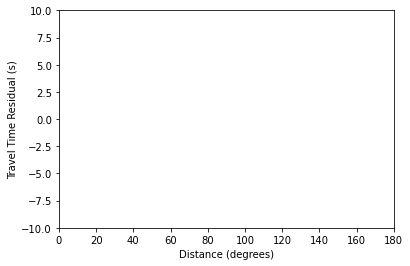

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
#
plt.plot(x,y,'ko')
plt.axis([0, 180, -10,10])
plt.ylabel('Travel Time Residual (s)')
plt.xlabel('Distance (degrees)')
plt.show()

#### Plot the Time Residual vs the Azimuth

In [51]:
# Extract the distance and timeResidual for data used in the location
x = []
y = []
for ap in arrivalTimePicks:
    if float(ap['timeWeight']) > 0.0:
        x.append(ap['azimuth'])
        y.append(ap['timeResidual'])
#

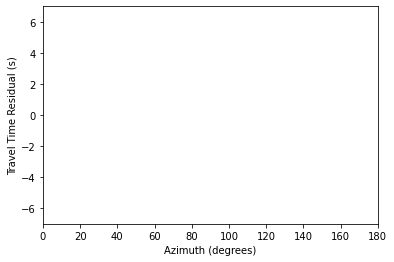

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
#
plt.plot(x,y,'ko')
plt.axis([0, 180, -7,7])
plt.ylabel('Travel Time Residual (s)')
plt.xlabel('Azimuth (degrees)')
plt.show()

#### Plot the Travel Times

To see a plot of the travel times requires that we convert the date-time strings into differences in seconds. I use python's datetime objects to handle this. The solution is not robust with time zones, but it works for UTC.

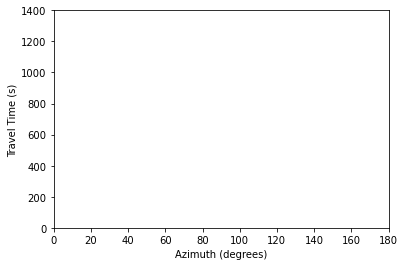

In [53]:
import datetime
def from_utc(utcTime,fmt="%Y-%m-%dT%H:%M:%S.%fZ"):
    return datetime.datetime.strptime(utcTime, fmt)
#
preferredOrigin = get_preferred_origin(events[0]['eventInfo'],events[0]['origins'])
originDateTime = from_utc(preferredOrigin['otime'])
# Extract the distance and timeResidual for data used in the location
x = []
y = []
for ap in arrivalTimePicks:
    if float(ap['timeWeight']) > 0.0:
        x.append(ap['distance'])
        dt = from_utc(ap['time']) - originDateTime
        y.append(dt.total_seconds())
# 
import matplotlib.pyplot as plt
%matplotlib inline
#
plt.plot(x,y,'ko')
plt.axis([0, 180, 0, 1400])
plt.ylabel('Travel Time (s)')
plt.xlabel('Azimuth (degrees)')
plt.show()